In [101]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import ctypes
from scipy.signal import savgol_filter
from scipy import signal
from scipy import stats
from sklearn.utils import resample
from sklearn.neighbors import KernelDensity
from scipy.stats import anderson_ksamp, ks_2samp
from scipy.special import expit
from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
#rc('text', usetex=True)

In [102]:
class proxy_lc():

    def __init__(self, file):
        
        self._lc_params = []
        lines = file.readlines()
        index_of_sep = [i for i in range(len(lines)) if lines[i] == "#\n"]
        list_pulse_param = np.array([float(line.rstrip('\n')) for line in  lines[:index_of_sep[0]]])
        norms = list_pulse_param[0::4]
        tdelays = list_pulse_param[1::4]
        taus = list_pulse_param[2::4]
        taurs = list_pulse_param[3::4]
        for i in range(len(norms)):
            self._lc_params.append({'norm': norms[i], 't_delay':tdelays[i], 'tau':taus[i] , 'tau_r': taurs[i]})

        self._ampl = float(lines[index_of_sep[0]+1])
        self._eff_area = float(lines[index_of_sep[0]+2])
        self._bg = float(lines[index_of_sep[0]+3])
        self._times = np.array([float(time.rstrip('\n')) for time in lines[index_of_sep[1]+1:]])
        self._n_pulses = 0
        self._verbose = False

    def norris_pulse(self, norm, tp, tau, tau_r):
        """
        Computes a single pulse according to Norris et al., ApJ, 459, 393 (1996)
        
        :t: times (lc x-axis), vector
        :tp: pulse peak time, scalar
        :tau: pulse width (decay time), scalar
        tau_r: rise time, scalar

        :returns: an array of count rates
        """

        self._n_pulses += 1
        
        if self._verbose:
            print("Generating a new pulse with tau={:0.3f}".format(tau))

        t   = self._times 
        _tp = np.ones(len(t))*tp
        
        if tau_r == 0 or tau == 0: 
            return np.zeros(len(t))
        
        return np.append(norm * np.exp(-(t[t<=tp]-_tp[t<=tp])**2/tau_r**2), \
                         norm * np.exp(-(t[t>tp] -_tp[t>tp])/tau))
        
        


        
        

In [103]:
lc_to_test = None
with open('test_lc_3.txt','r') as in_file:
    lc_to_test = proxy_lc(in_file)


In [104]:
def count_significative_pulses_ver2(lc, verbose=False, sn_min = 15):

    bin_time = 0.064
    """
    NEW VER - TO WRITE
    Input:
    - lc: object that contains the light curve;
    Output:
    - n_of_sig_pulses: number of significative pulses;
    - n_of_total_pulses: number of total pulses generated for the LC;
    """
    def make_pulse(pulse, ampl, eff_area):
        norm    = pulse['norm']
        t_delay = pulse['t_delay']
        tau     = pulse['tau']
        tau_r   = pulse['tau_r']

        pulse_curve = lc.norris_pulse(norm, t_delay, tau, tau_r) * ampl * eff_area
        return pulse_curve
    
    def evaluate_fwhm_norris(pulse):
        t_delay = pulse['t_delay']
        tau     = pulse['tau']
        tau_r   = pulse['tau_r']

        t_1 = t_delay - tau_r * np.sqrt(np.log(2))
        t_2 = t_delay + tau   * np.log(2)
        peak_fwhm = t_2 - t_1

        # import matplotlib.pyplot as plt
        # y = lc.norris_pulse(pulse['norm'], pulse['t_delay'], pulse['tau'], pulse['tau_r'])
        # plt.figure()
        # plt.plot(lc._times, y/max(y))
        # plt.plot([t_1, t_1],[0,1])
        # plt.plot([t_2, t_2],[0,1])
        # plt.xlim(-10,100)

        return peak_fwhm
    
    def evaluate_fwhm_general(counts, times, threshold = 0.05, filter = False, filter_window = 11):
        
        if filter:
            counts = savgol_filter(x=counts, 
                                   window_length=filter_window,
                                   polyorder=2)
        norm_counts = counts / np.max(counts)

        try:
            i_min = np.where(norm_counts >= 0.5*(1.-threshold))[0][0]
            i_max = np.where(norm_counts >= 0.5*(1.-threshold))[0][-1] 
            if i_min == i_max:
                i_min -= 1
                i_max += 1
            t_min = times[i_min]
            t_max = times[i_max]
            #t_min = times[norm_counts >= 0.5*(1.-threshold)][0]
            #t_max = np.flip(times)[np.flip(norm_counts) >= 0.5*(1.-threshold)][0]
        
            fwhm = t_max - t_min
        except:
            fwhm = np.inf

        return fwhm

    def evaluate_deltaTmin(impulses_time):
        if len(impulses_time) >= 2:
            deltaT_min = [min(abs(impulses_time[i] - impulses_time[i-1]), abs(impulses_time[i] - impulses_time[i+1])) for i in range(1,len(impulses_time)-1)  ]
            deltaT_min.insert(0, abs(impulses_time[1]-impulses_time[0]))
            deltaT_min.append(abs(impulses_time[-1] - impulses_time[-2]))
        else:
            deltaT_min = np.array([np.inf])
        return deltaT_min
    
    def evaluate_logSN(counts, noise_level):
        ## to remove ####
        #noise_level = 0.001 * noise_level
        ##################
        counts_signal_threshold = 0.2
        error_threshold = 0.05
        counts_norm = counts / np.max(counts)

        try: 
            # print(counts_norm)
            # print(np.where(counts_norm >= 0.19))
            # print(np.where(counts_norm >= counts_signal_threshold*(1.-error_threshold)))
            i_min = np.where(counts_norm >= counts_signal_threshold*(1.-error_threshold))[0][0]
            i_max = np.where(counts_norm >= counts_signal_threshold*(1.-error_threshold))[0][-1] 
            if i_min == i_max:
                i_min -= 1
                i_max += 1
            signal = np.sum(counts[i_min:i_max+1])
            noise = noise_level * (i_max - i_min) 
            print(signal, noise)

            # import matplotlib.pyplot as plt
            # plt.figure()
            # plt.plot(counts, marker = '+')
            # plt.plot([i_min,i_min],[0,max(counts)])
            # plt.plot([i_max,i_max],[0,max(counts)])
            # plt.xlim([i_min-5, i_max +5])
            # plt.show()

        except:
            signal = 0
            noise = noise_level

        log_SN = np.log10(signal/noise)

        return log_SN
    
    #from MEPSA paper eq. 3
    # log s0.9 = -8.28 log SN + 8.42 if logSN < 0.95
    #            -0.64 log SN + 1.15 if logSN > 0.95
    def test_significativity(pulse_par):
        logs = pulse_par[0]
        logSN  = pulse_par[1]
        significative = False
        if logSN < 0.95:
            if logs > -8.28 * logSN + 8.42:
                significative = True
            else:
                significative = False
        else:
            if logs > -0.64 * logSN + 1.15:
                significative = True
            else:
                significative = False
        
        return significative


    pulses_param_list = lc._lc_params
    ampl              = lc._ampl
    eff_area          = lc._eff_area
    times = lc._times

    n_of_sig_pulses      = 0
    significative_pulses = []
    n_of_total_pulses    = len(pulses_param_list)

    delay_factor   = 2 
    minimum_pulse_delay = delay_factor * bin_time
    noise = np.round(lc._bg * bin_time) #Bkg per bin
    print(noise)

    all_pulses = list(map(make_pulse, pulses_param_list, [ampl]*len(pulses_param_list), [eff_area]*len(pulses_param_list)))
    all_pulses = np.reshape(all_pulses, newshape=(len(pulses_param_list), len(times)))
    print("Total number of generated pulses: ",  len(all_pulses))

    import matplotlib.pyplot as plt
    plt.figure()
    for pulse in all_pulses:
        plt.plot(times, pulse)
        #plt.xlim([-2.5,2.5])
        

    if len(pulses_param_list) == 1 :
        pulse_sn = evaluate_logSN(all_pulses, noise)
        if pulse_sn > sn_min:
            n_of_sig_pulses = 1
    else:
        # EVALUATE SEPARABILITY ####################################

        pulses_param_list = sorted(pulses_param_list, key=lambda pulse: pulse['t_delay'])
        print(pulses_param_list)
        fwhms = np.array(list(map(evaluate_fwhm_norris, pulses_param_list)))
        print(fwhms)
        impulses_time = np.array([pulse['t_delay'] for pulse in pulses_param_list])
        deltaT_min = evaluate_deltaTmin(impulses_time)
        print(deltaT_min)
        #separability s0.9 = deltaT_min /fwhm
        log_s = np.log10(deltaT_min/fwhms)
        print(log_s)
        # EVALUATE S/N ################################################
        log_SN = np.array(list(map(evaluate_logSN, all_pulses, [noise]*len(all_pulses))))
        print(log_SN)
        ## REGROUP THE PULSES #########################################
        pulses_significativity = np.array(list(map(test_significativity, zip(log_s, log_SN))))
        print(pulses_significativity)
        print("Total number of generated separable pulses: ", len(pulses_significativity[pulses_significativity == True]))
        
        ###Regroup logic must be rewritten#####
        pulses_regroup = []
        subgroup = []

        for i in range(len(pulses_significativity)):
           sign = pulses_significativity[i]
           if sign:
               subgroup.append(i)
               pulses_regroup.append(subgroup)
               subgroup = []
           else:
               subgroup.append(i)
               new_pulse = all_pulses[i,:] + all_pulses[i+1,:]
               fwhm_new = evaluate_fwhm_general(new_pulse, times)
               new_time = np.mean([pulses_param_list[i]['t_delay'],pulses_param_list[i+1]['t_delay']])
               delta_t_new = min(abs(new_time - pulses_param_list[i-1]['t_delay']), abs(new_time - pulses_param_list[i+1]['t_delay']))
               log_s_new = np.log10(delta_t_new/fwhm_new)
               log_SN = evaluate_logSN(new_pulse, noise)
               test_sig = test_significativity((log_s_new, log_SN))
               if test_sig:
                   pulses_regroup.append(subgroup)
                   subgroup = []
                #else:
                #    pass
        #for i in range(len(pulses_significativity)):
        #    subgroup.append(i)
        #    if pulses_significativity[i]:
        #        if len(subgroup) > 1:
        #            pulses_regroup.append(subgroup[:len(subgroup)-1])
        #        pulses_regroup.append([subgroup[-1]])
        #        subgroup = []

        #if subgroup != []:
        #    pulses_regroup.append(subgroup)

        print(pulses_regroup)
        
        #Regroup the pulses: sum ogether all the non significative pulses and keep the already significative pulses
        regroup_pulses = [np.sum(all_pulses[group], axis = 0) for group in pulses_regroup]
        regroup_pulses =  np.reshape(regroup_pulses, newshape=(len(regroup_pulses), len(times)))

        regroup_times = np.array([np.mean(impulses_time[group])  for group in pulses_regroup])
        print(regroup_times)
        print("Total number of regrouped pulses: ", len(regroup_pulses))

        plt.figure()
        for pulse in regroup_pulses:
            plt.plot(times, pulse, alpha = 0.2)
            #plt.xlim([-2.5,2.5])
    
        ## TEST SIGNIFICATIVITY OF THE REGROUP PULSES #################################
        fwhms_reg = np.array(list(map(evaluate_fwhm_general, regroup_pulses, [times]*len(times))))
        print(fwhms_reg)

        if len(regroup_times) >= 2:
            deltaT_min_regr = evaluate_deltaTmin(regroup_times)
        else:
            deltaT_min_regr = [np.inf]

        log_s_regr = np.log10(deltaT_min_regr/fwhms_reg)

        ##Va bene usare lo stesso noise di prima? Bisogna pensarci
        log_SN_regr = np.array(list(map(evaluate_logSN, regroup_pulses, [noise]*len(regroup_pulses))))

        re_pulses_significativity = np.array(list(map(test_significativity, zip(log_s_regr, log_SN_regr))))
        print("Total number of significative regrouped pulses: ",  len(re_pulses_significativity[re_pulses_significativity == True]))
        ## DO NOT COUNT PULSES WITH LESS THAN 2 BIN SEPARATION
        if len(re_pulses_significativity) >=2:
            n_of_sig_pulses = 1
            sig_impulse_times = regroup_times[re_pulses_significativity]
            #time_diffs = np.diff(sig_impulse_times)
            #n_of_sig_pulses = len(re_pulses_significativity[time_diffs > minimum_pulse_delay])
            for i in range(1, len(sig_impulse_times)):
                if sig_impulse_times[i] - sig_impulse_times[i-1] >= minimum_pulse_delay:
                    n_of_sig_pulses+= 1
        else:
            n_of_sig_pulses = len(re_pulses_significativity)
    
    n_of_total_pulses = len(pulses_param_list)

    #TO BE CHANGED
    lc._minimum_peak_rate_list   = None
    lc._peak_rate_list           = None
    lc._current_delay_list       = None
    lc._minimum_pulse_delay_list = None

    if verbose:
        print('-------------------------------------')
        print('Number of generated pulses: ', len(pulses_param_list))
        print('Number of significative pulses: ', n_of_sig_pulses)
        print('-------------------------------------')

    #Come ritorno la lista degli inpulsi significativi? 
    print("Final number of significative pulses: ", n_of_sig_pulses)
    return n_of_sig_pulses, n_of_total_pulses, None

2458.0
Total number of generated pulses:  6
[{'norm': 0.13724400621554161, 't_delay': 5.2859959766763436e-05, 'tau': 7.345034633118272e-05, 'tau_r': 3.672517316559136e-05}, {'norm': 1.568520152463786, 't_delay': 0.00023265050944118112, 'tau': 0.0011099267769527506, 'tau_r': 0.0005549633884763753}, {'norm': 1.4477972782461304, 't_delay': 0.0004468540524384665, 'tau': 7.350165164160783e-05, 'tau_r': 3.675082582080392e-05}, {'norm': 1.2323062505134503, 't_delay': 0.002963513173498708, 'tau': 0.001010713410302125, 'tau_r': 0.0005053567051510625}, {'norm': 0.42642623711774075, 't_delay': 4.735083703420617, 'tau': 13.632680525904341, 'tau_r': 6.8163402629521705}, {'norm': 2.0664244113386823, 't_delay': 41.66779009902852, 'tau': 11.417096471717493, 'tau_r': 5.708548235858746}]
[8.14876127e-05 1.23137994e-03 8.15445321e-05 1.12131021e-03
 1.51244296e+01 1.26664064e+01]
[0.00017979054967441767, 0.00017979054967441767, 0.00021420354299728537, 0.0025166591210602418, 4.732120190247119, 36.93270639

(2, 6, None)

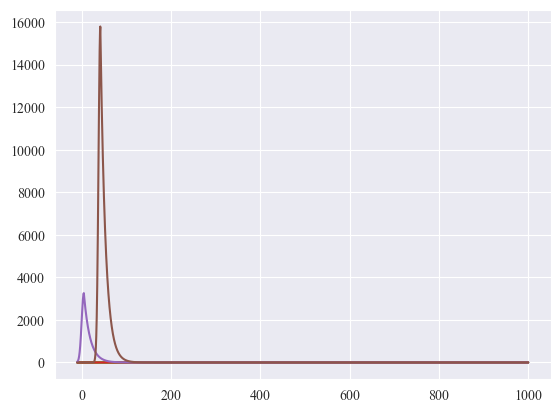

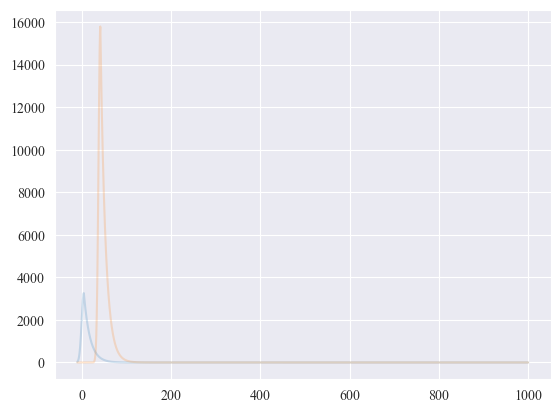

In [105]:
count_significative_pulses_ver2(lc_to_test)